In [16]:
import math
import os.path
from os import listdir, path
from os.path import isfile, join
import datetime
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot


from pyapnea.oscar.oscar_loader import load_session
from pyapnea.oscar.oscar_getter import event_data_to_dataframe, get_channel_from_code
from pyapnea.oscar.oscar_constants import CHANNELS, ChannelID

In [17]:
# init notebook parameters
init_notebook_mode(connected=True)
#pd.set_option('display.max_rows', None)

In [18]:
data_path_cpap1 = '../data/raw/ResMed_23192565579/Events'
list_files = [{'label': f, 'value': f, 'fullpath': join(data_path_cpap1, f)} for f in listdir(data_path_cpap1) if isfile(join(data_path_cpap1, f))]
data_path_cpap2= '../data/raw/ResMed_23221085377/Events'
list_files.extend([{'label': f, 'value': f, 'fullpath': join(data_path_cpap2, f)} for f in listdir(data_path_cpap2) if isfile(join(data_path_cpap2, f))])


In [19]:
def event_data_to_dataframe_all_channel(oscar_session_data):
    global_df = pd.DataFrame(columns=['Col1'])
    possible_channels = [ChannelID.CPAP_FlowRate.value, ChannelID.CPAP_Obstructive.value, ChannelID.CPAP_Pressure.value]
    for channel in oscar_session_data.data.channels:
        if channel.code in possible_channels:
            y_col_name = [c[5] for c in CHANNELS if c[1].value == channel.code][0]
            gain = channel.events[0].gain
            if channel.events[0].t8 == 0:
                channel.events[0].time = range(0, channel.events[0].evcount * int(channel.events[0].rate),
                                               int(channel.events[0].rate))
            df = pd.DataFrame(data={'time': channel.events[0].time,
                                    y_col_name+'_no_gain': channel.events[0].data})
            df[y_col_name] = df[y_col_name+'_no_gain'] * gain

            if channel.events[0].second_field:
                # not tested because do not have 2nd field in files
                df[y_col_name+'2_no_gain'] = channel.events[0].data2
                df[y_col_name + '2'] = df[y_col_name+'2_no_gain'] * gain

            df['time_utc'] = df['time'] + channel.events[0].ts1
            df['time_utc'] = pd.to_datetime(df['time_utc'], unit='ms')
            #df.set_index('time_absolute', inplace=True)
            df = df.filter(regex='^(?!.*_no_gain)')
            if global_df.empty:
                global_df = df
            else:
                #global_df = pd.merge(global_df, df, right_index=True, left_index=True, how='outer')
                global_df = pd.merge(global_df, df, on='time_utc', how='outer',suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
                #global_df = pd.concat([global_df, df])

    global_df['time_utc'] = global_df['time_utc'].dt.tz_localize('UTC')
    global_df['local_time'] = global_df['time_utc'].dt.tz_convert('America/Montreal')
    global_df.sort_index(inplace=True)
    return global_df

# Displaying one session and the first event

In [20]:
# reading files
# number 2 has obstructive events
filename_to_load = '../data/raw/ResMed_23192565579/Events/62202198.001'

oscar_session_data = load_session(filename_to_load)
df = event_data_to_dataframe_all_channel(oscar_session_data)

# TODO handle Leak two value per time
#df_Leak = event_data_to_dataframe(oscar_session_data, ChannelID.CPAP_Leak.value)
#np.where(df.index.duplicated(keep=False) == True)

display(df)


,time,Pressure,time_utc,FlowRate,Obstructive,local_time
0,0.0,4.00,2022-03-03 02:03:02+00:00,-26.640001,NaN,2022-03-02 21:03:02-05:00
1,676000.0,4.02,2022-03-03 02:14:18+00:00,-6.840000,NaN,2022-03-02 21:14:18-05:00
2,680000.0,4.08,2022-03-03 02:14:22+00:00,-4.320000,NaN,2022-03-02 21:14:22-05:00
3,684000.0,4.26,2022-03-03 02:14:26+00:00,-0.720000,NaN,2022-03-02 21:14:26-05:00
4,688000.0,4.40,2022-03-03 02:14:30+00:00,-3.360000,NaN,2022-03-02 21:14:30-05:00
...,...,...,...,...,...,...
721496,NaN,NaN,2022-03-03 10:03:50.800000+00:00,-19.920001,NaN,2022-03-03 05:03:50.800000-05:00
721497,NaN,NaN,2022-03-03 10:03:50.840000+00:00,-19.320001,NaN,2022-03-03 05:03:50.840000-05:00
721498,NaN,NaN,2022-03-03 10:03:50.880000+00:00,-18.360001,NaN,2022-03-03 05:03:50.880000-05:00
721499,NaN,NaN,2022-03-03 10:03:50.920000+00:00,-16.680001,NaN,2022-03-03 05:03:50.920000-05:00


In [21]:
# reorganize dataframe to seaborn imput format
dfc = df[['FlowRate', 'Obstructive', 'Pressure', 'local_time']]
dfm = dfc.melt('local_time', var_name='cols', value_name='vals')
dfm.sort_values(by=['local_time'], inplace=True, ignore_index=True)
dfm_annotation = dfm[(~pd.isnull(dfm['vals']) & (dfm['cols']=='Obstructive'))]
display(dfm_annotation)

,local_time,cols,vals
446851,2022-03-02 22:42:09-05:00,Obstructive,18.0


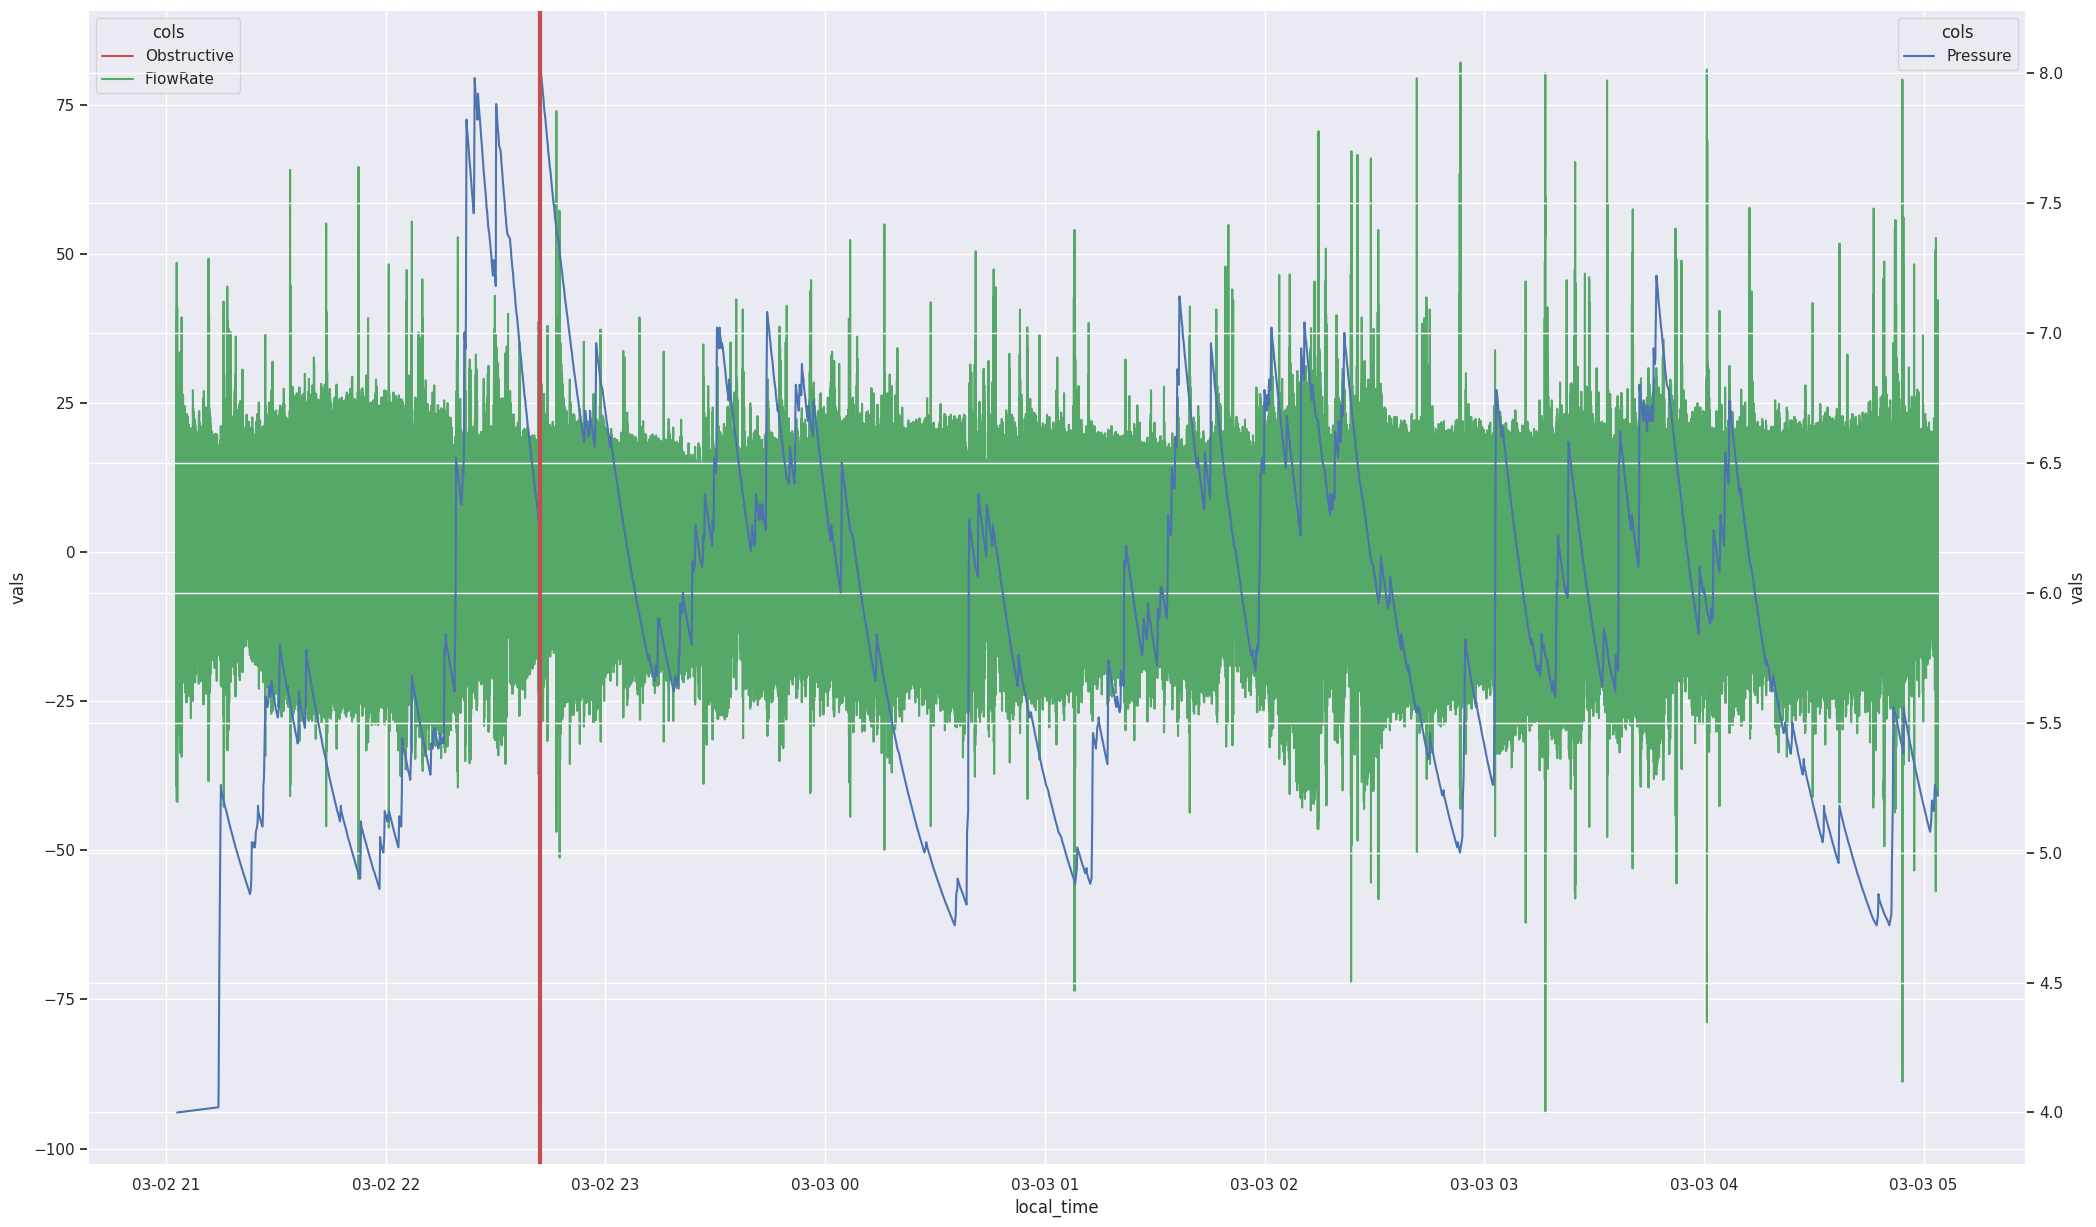

In [22]:
sns.set(rc={'figure.figsize':(25,15)})
fig, ax = plt.subplots()
sns.lineplot(data=dfm[dfm['cols']!='Pressure'],x='local_time', y='vals', hue='cols', palette=['r', 'g'], ax= ax)
ax2 = ax.twinx()
# warning : should not interpolate between points...
sns.lineplot(data=dfm[dfm['cols']=='Pressure'],x='local_time', y='vals', hue='cols', palette=['b'], ax = ax2)
for a in dfm_annotation['local_time']:
    plt.axvline(x=a, color='r', linewidth=3)

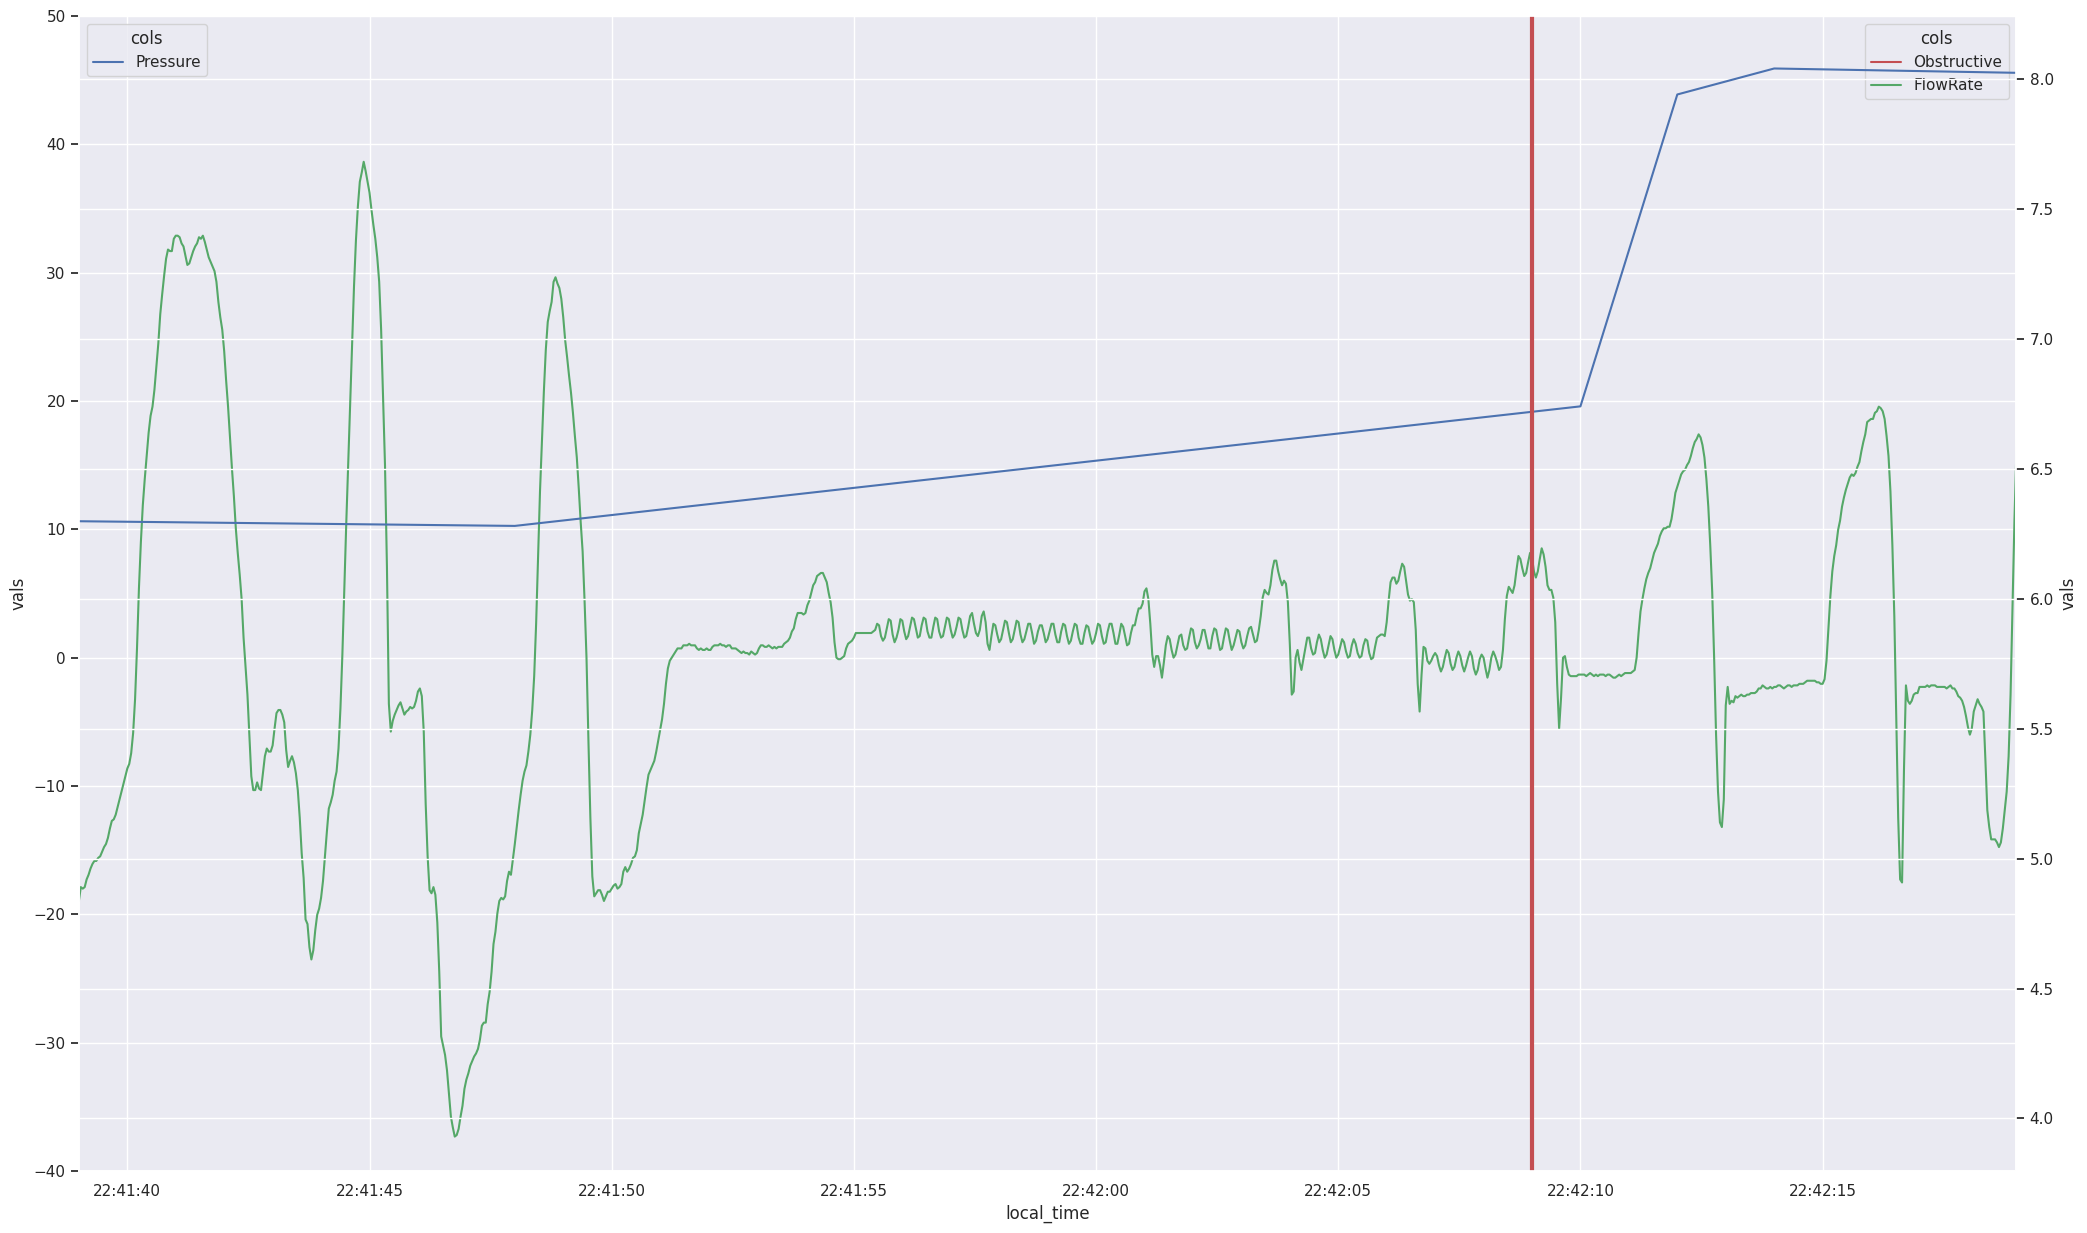

In [23]:
event_time = dfm_annotation['local_time'].iloc[0]
sns.set(rc={'figure.figsize':(25,15)})
fig, ax = plt.subplots()

ax.set_ylim(-40, 50)
ax.set_xlim(event_time - datetime.timedelta(seconds=30), event_time + datetime.timedelta(seconds=10))
sns.lineplot(data=dfm[dfm['cols']!='Pressure'],x='local_time', y='vals', hue='cols', palette=['r', 'g'], ax = ax)
ax2 = ax.twinx()
# warning : should not interpolate between points...
sns.lineplot(data=dfm[dfm['cols']=='Pressure'],x='local_time', y='vals', hue='cols', palette=['b'], ax = ax2)
for a in dfm_annotation['local_time']:
    plt.axvline(x=a, color='r', linewidth=3)

# Statistics
- Number of sessions
- Lenght of sessions

In [24]:
events_channels = [ChannelID.CPAP_ClearAirway.value,
                   ChannelID.CPAP_Obstructive.value,
                   ChannelID.CPAP_Hypopnea.value,
                   ChannelID.CPAP_Apnea.value, # ClearAway or Obstructive, not determined
                   ]
event_names = [[c[5] for c in CHANNELS if c[1].value == e][0] for e in events_channels]
event_names

['ClearAirway', 'Obstructive', 'Hypopnea', 'Apnea']

In [25]:
stats = dict()
stats['nb_sessions'] = len(list_files)
stats['sessions'] = []



df_event_all_sessions = None

#loading all files
with tqdm(total=len(list_files)) as pbar:
    for f in list_files:
        oscar_session_data = load_session(f['fullpath'])
        # FlowRate
        flowrate_chanel = get_channel_from_code(oscar_session_data, ChannelID.CPAP_FlowRate.value)
        flowrate_event = flowrate_chanel.events[0]

        stat_session = {'filename': f['label'],
                        'nb channel': len(oscar_session_data.data.channels),
                        'ts1' : flowrate_event.ts1,
                        'ts2' : flowrate_event.ts2,
                        'starting time' : datetime.datetime.fromtimestamp(flowrate_event.ts1/1000.0),
                        'lenght FlowRate (ms)': flowrate_event.ts2 - flowrate_event.ts1,
                        'FlowRate present': (ChannelID.CPAP_FlowRate.value in [c.code for c in oscar_session_data.data.channels])}

        # Events
        stat_session['events'] = []
        for e in events_channels:
            event_name = [c[5] for c in CHANNELS if c[1].value == e][0]
            event_channel_df = event_data_to_dataframe(oscar_session_data, e)
            if not event_channel_df.empty:
                df_event = event_channel_df[~pd.isnull(event_channel_df[event_name])]
                df_event['type']  = event_name
                df_event['session'] = f['value']
            else:
                df_event = pd.DataFrame(data=[[np.NAN, event_name, f['value']]], columns=['time_utc', 'type', 'session'])
            if df_event_all_sessions is None:
                df_event_all_sessions = df_event[['time_utc', 'type', 'session']]
            else:
                df_event_all_sessions = pd.concat([df_event_all_sessions,  df_event[['time_utc', 'type', 'session']]])
        stats['sessions'].append(stat_session)
        pbar.update(1)
        oscar_session_data = None


# All event per session
print(df_event_all_sessions)

  0%|          | 0/999 [00:00<?, ?it/s]

                    time_utc         type       session
0                        NaT  ClearAirway  61fb6e70.001
0                        NaT  Obstructive  61fb6e70.001
0                        NaT     Hypopnea  61fb6e70.001
0                        NaT        Apnea  61fb6e70.001
0                        NaT  ClearAirway  6218853c.001
..                       ...          ...           ...
0                        NaT        Apnea  624ff4e0.001
0                        NaT  ClearAirway  64506a2c.001
0  2023-05-02 03:21:39+00:00  Obstructive  64506a2c.001
0                        NaT     Hypopnea  64506a2c.001
0                        NaT        Apnea  64506a2c.001

[5889 rows x 3 columns]


In [26]:
# stats for event
# number of event per type
df_count_per_type = df_event_all_sessions.groupby(['type'])['time_utc'].count().to_frame(name = 'count').reset_index().sort_values('type')
# number of event per type per session
df_count_per_type_per_session = df_event_all_sessions.groupby(['session', 'type'])['time_utc'].count().to_frame(name = 'count').reset_index().sort_values('type')
print(df_count_per_type)
print(df_count_per_type_per_session)

          type  count
0        Apnea     13
1  ClearAirway   1590
2     Hypopnea    435
3  Obstructive   1089
           session         type  count
0     61f1fbb0.001        Apnea      0
948   6270f078.001        Apnea      0
2576  636f6504.001        Apnea      0
944   6270e754.001        Apnea      0
2580  637074a8.001        Apnea      0
...            ...          ...    ...
2715  638970c0.001  Obstructive      1
855   62636520.001  Obstructive      3
2711  63883098.001  Obstructive      5
1035  627cbd54.001  Obstructive      1
3995  64618758.001  Obstructive      1

[3996 rows x 3 columns]


In [27]:
stats

{'nb_sessions': 999,
 'sessions': [{'filename': '61fb6e70.001',
   'nb channel': 18,
   'ts1': 1643867765000,
   'ts2': 1643869205000,
   'starting time': datetime.datetime(2022, 2, 3, 0, 56, 5),
   'lenght FlowRate (ms)': 1440000,
   'FlowRate present': True,
   'events': []},
  {'filename': '6218853c.001',
   'nb channel': 18,
   'ts1': 1645774156000,
   'ts2': 1645786096000,
   'starting time': datetime.datetime(2022, 2, 25, 2, 29, 16),
   'lenght FlowRate (ms)': 11940000,
   'FlowRate present': True,
   'events': []},
  {'filename': '6226a9a0.001',
   'nb channel': 20,
   'ts1': 1646700982000,
   'ts2': 1646716582000,
   'starting time': datetime.datetime(2022, 3, 7, 19, 56, 22),
   'lenght FlowRate (ms)': 15600000,
   'FlowRate present': True,
   'events': []},
  {'filename': '620f4b70.001',
   'nb channel': 18,
   'ts1': 1645169544000,
   'ts2': 1645169904000,
   'starting time': datetime.datetime(2022, 2, 18, 2, 32, 24),
   'lenght FlowRate (ms)': 360000,
   'FlowRate present': 

In [28]:
def ms_to_hour_min_sec_ms(ms):
    sec, ms = divmod(ms, 1000)
    min, sec = divmod(sec, 60)
    hour, min = divmod(min, 60)
    return hour, min, sec, ms

In [29]:
import statistics as stat
import math
# FlowRate
length_array = np.array([s['lenght FlowRate (ms)'] for s in stats['sessions']])
avg_len = length_array.mean()
med_len = np.median(length_array)
stddev_len = stat.stdev(length_array.tolist())
stats['FlowRate average length (ms)'] = avg_len
stats['FlowRate stddev (ms)'] = stddev_len
stats['FlowRate median (ms)'] = med_len
stats['FlowRate average length (hmsms))'] = ms_to_hour_min_sec_ms(avg_len)
stats['FlowRate stddev (hmsms)'] = ms_to_hour_min_sec_ms(stddev_len)
stats['FlowRate median (hmsms)'] = ms_to_hour_min_sec_ms(med_len)

# Events
stats['events'] = {'count': pd.Series(df_count_per_type['count'].values,index=df_count_per_type['type']).to_dict()}
stats['events']['average_sess'] = {e: df_count_per_type_per_session[df_count_per_type_per_session['type']==e].mean(numeric_only=True).to_list()[0] for e in event_names}
stats['events']['stddev_sess'] = {e: stat.stdev(df_count_per_type_per_session[df_count_per_type_per_session['type']==e]['count']) for e in event_names}
stats['events']['median'] = {e: stat.median(df_count_per_type_per_session[df_count_per_type_per_session['type']==e]['count']) for e in event_names}

In [30]:
stats

{'nb_sessions': 999,
 'sessions': [{'filename': '61fb6e70.001',
   'nb channel': 18,
   'ts1': 1643867765000,
   'ts2': 1643869205000,
   'starting time': datetime.datetime(2022, 2, 3, 0, 56, 5),
   'lenght FlowRate (ms)': 1440000,
   'FlowRate present': True,
   'events': []},
  {'filename': '6218853c.001',
   'nb channel': 18,
   'ts1': 1645774156000,
   'ts2': 1645786096000,
   'starting time': datetime.datetime(2022, 2, 25, 2, 29, 16),
   'lenght FlowRate (ms)': 11940000,
   'FlowRate present': True,
   'events': []},
  {'filename': '6226a9a0.001',
   'nb channel': 20,
   'ts1': 1646700982000,
   'ts2': 1646716582000,
   'starting time': datetime.datetime(2022, 3, 7, 19, 56, 22),
   'lenght FlowRate (ms)': 15600000,
   'FlowRate present': True,
   'events': []},
  {'filename': '620f4b70.001',
   'nb channel': 18,
   'ts1': 1645169544000,
   'ts2': 1645169904000,
   'starting time': datetime.datetime(2022, 2, 18, 2, 32, 24),
   'lenght FlowRate (ms)': 360000,
   'FlowRate present': 

# Length

[Text(0.5, 0, 'Sessions'), Text(0, 0.5, 'Length (hour)')]

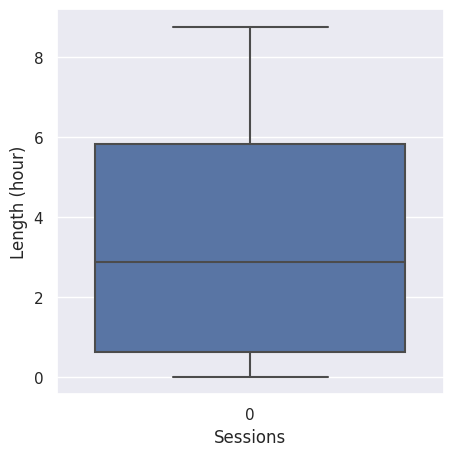

In [31]:
sns.set(rc={'figure.figsize':(5,5)})
sns.boxplot(data=length_array/1000.0/60/60).set(xlabel='Sessions', ylabel='Length (hour)')

[Text(0.5, 0, 'Sessions'), Text(0, 0.5, 'Length (hour)')]

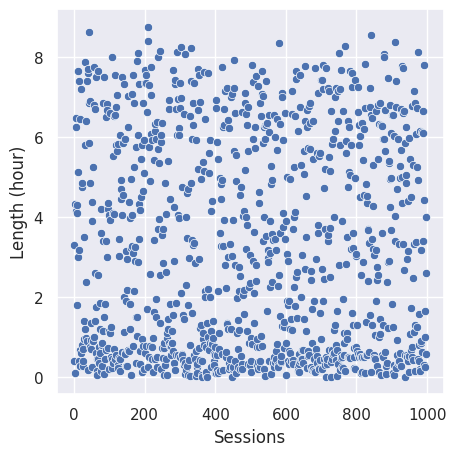

In [36]:
sns.scatterplot(data=length_array/1000.0/60/60).set(xlabel='Sessions', ylabel='Length (hour)')

# Events

[Text(0.5, 0, 'type of event'),
 Text(0, 0.5, 'Nb events per session (avg+stdev)')]

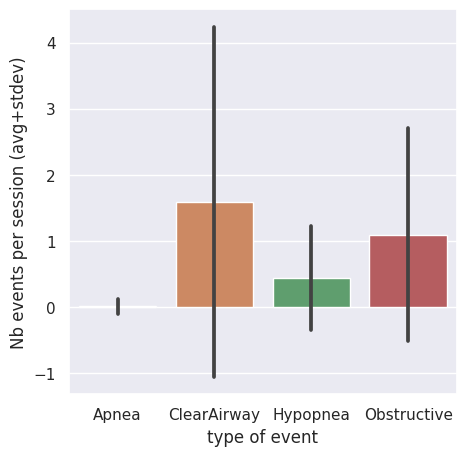

In [32]:
# nb event per session (average + stddev)
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(data=df_count_per_type_per_session, x='type', y='count', errorbar='sd').set(xlabel='type of event', ylabel='Nb events per session (avg+stdev)')

[Text(0.5, 0, 'type of event'),
 Text(0, 0.5, 'Nb events per session (avg+stderr)')]

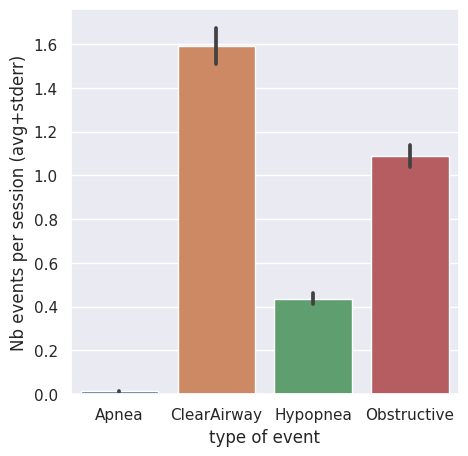

In [33]:
# nb event per session (average + stderr)
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(data=df_count_per_type_per_session, x='type', y='count', errorbar='se').set(xlabel='type of event', ylabel='Nb events per session (avg+stderr)')

<Axes: xlabel='type', ylabel='count'>

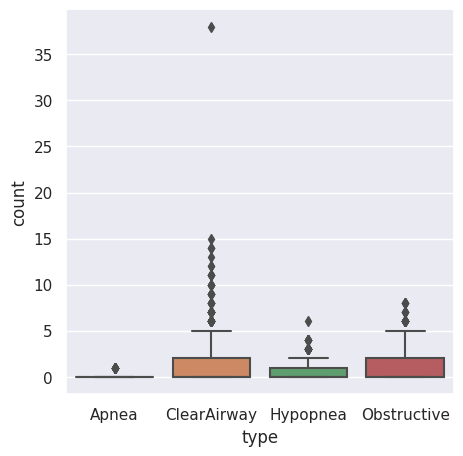

In [34]:
sns.boxplot(data=df_count_per_type_per_session, x='type', y='count')

[Text(0.5, 0, 'type of event'), Text(0, 0.5, 'Nb events per type')]

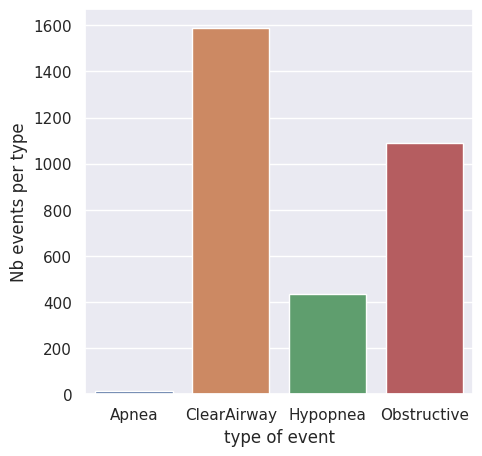

In [35]:
# nb event per type
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(data=df_count_per_type, x='type', y='count').set(xlabel='type of event', ylabel='Nb events per type')